In [1]:
import torch
import sys
import os, json
from numpy import interp
import warnings
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchinfo import summary
from sklearn.metrics import auc, f1_score, roc_curve, classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import cycle
import pandas as pd

In [2]:
df = pd.read_csv('./milknew.csv')
df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


In [3]:
df['Grade'].unique()

array(['high', 'low', 'medium'], dtype=object)

In [4]:
target_dict = {k: v for k, v in enumerate(df['Grade'].unique())}
class_indices = {k: v for v, k in enumerate(df['Grade'].unique())}

json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)
with open('./classes_indices.json', 'w') as json_file:
    json_file.write(json_str)

In [8]:
df['Grade'] = df['Grade'].map(class_indices)

In [9]:
df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,0
1,6.6,36,0,1,0,1,253,0
2,8.5,70,1,1,1,1,246,1
3,9.5,34,1,1,0,1,255,1
4,6.6,37,0,0,0,0,255,2


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 66.3 KB


In [11]:
train_df, valid_df = train_test_split(df, test_size=0.3)

In [19]:
class MyDataset(Dataset):
    
    def __init__(self, df):
        
        self.features = torch.FloatTensor(np.array(df.drop(['Grade'], axis=1)))
        self.targets = torch.LongTensor(np.array(df['Grade']))
    
    def __getitem__(self, idx):
        x_sample = self.features[idx]
        y_sample = self.targets[idx]
        return x_sample, y_sample
    
    def __len__(self):
        return self.features.shape[0]

In [20]:
train_set = MyDataset(train_df)
valid_set = MyDataset(valid_df)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=False)

In [21]:
for x, y in train_loader:
    print(x.size())
    print(y.size())
    break

torch.Size([16, 7])
torch.Size([16])


In [22]:
model = nn.Sequential(
    nn.Linear(7, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 3),
)

In [23]:
summary(model, input_size=(16, 7))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 3]                   --
├─Linear: 1-1                            [16, 32]                  256
├─BatchNorm1d: 1-2                       [16, 32]                  64
├─ReLU: 1-3                              [16, 32]                  --
├─Linear: 1-4                            [16, 64]                  2,112
├─ReLU: 1-5                              [16, 64]                  --
├─Linear: 1-6                            [16, 128]                 8,320
├─ReLU: 1-7                              [16, 128]                 --
├─Linear: 1-8                            [16, 3]                   387
Total params: 11,139
Trainable params: 11,139
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.04
Estimated Total Size (MB): 0.08

In [39]:
def train_step(model, optimizer, data_loader, epoch, device):
    
    model.train()
    
    model.to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    
    train_loss, sample, train_acc = 0, 0, 0
    
    train_bar = tqdm(data_loader, file=sys.stdout, colour='red')
    
    for step, data in enumerate(train_bar):
        features, targets = data
        
        sample += features.shape[0]
        features = features.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(features)
        
        loss = loss_fn(outputs, targets)
        train_loss += loss.item()
        
        train_acc += (torch.argmax(outputs, dim=1) == targets).sum().item()
        
        loss.backward()
        optimizer.step()
        
        train_bar.desc = f'[train epoch {epoch}], loss is {train_loss/(step + 1)}, accuracy is {train_acc/sample}'
    
    return round(train_loss/(step + 1), 4), round((train_acc/sample), 4)

In [40]:
@torch.no_grad()
def valid_step(model, data_loader, epoch, device):
    
    model.eval()
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    
    valid_loss, sample, valid_acc = 0, 0, 0
    valid_bar = tqdm(data_loader, file=sys.stdout, colour='red')
    
    for step, data in enumerate(valid_bar):
        features, targets = data
        
        sample += features.shape[0]
        features = features.to(device)
        targets = targets.to(device)
        
        outputs = model(features)
        
        loss = loss_fn(outputs, targets)
        valid_loss += loss.item()
        
        valid_acc += (torch.argmax(outputs, dim=1) == targets).sum().item()
        
        valid_bar.desc = f'[valid epoch {epoch}], loss is {valid_loss/(step + 1)}, accuracy is {valid_acc/sample}'
    
    return round(valid_loss/(step + 1), 4), round((valid_acc/sample), 4)

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [42]:
best_accuracy = 0.0

for epoch in range(epochs):
    
    train_loss, train_accuracy = train_step(model, optimizer, train_loader, epoch, device)
    
    valid_loss, valid_accuracy = valid_step(model, valid_loader, epoch, device)
    
    if valid_accuracy > best_accuracy:
        checkpoint = {'model': model.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'best_accuracy': valid_accuracy}
        best_accuracy = valid_accuracy
        
        torch.save(checkpoint, 'model.pth')

[train epoch 0], loss is 0.18750970644202639, accuracy is 0.921727395411606: 100%|████| 47/47 [00:00<00:00, 310.96it/s]
[valid epoch 0], loss is 1.3591233611106872, accuracy is 0.5660377358490566: 100%|███| 20/20 [00:00<00:00, 1111.19it/s]
[train epoch 1], loss is 0.1350278789177537, accuracy is 0.9392712550607287: 100%|████| 47/47 [00:00<00:00, 348.15it/s]
[valid epoch 1], loss is 0.70108104031533, accuracy is 0.8490566037735849: 100%|██████| 20/20 [00:00<00:00, 999.97it/s]
[train epoch 2], loss is 0.1936254583774729, accuracy is 0.9082321187584346: 100%|████| 47/47 [00:00<00:00, 356.06it/s]
[valid epoch 2], loss is 0.17230083048343658, accuracy is 0.9276729559748428: 100%|██| 20/20 [00:00<00:00, 1111.13it/s]
[train epoch 3], loss is 0.15993414375376194, accuracy is 0.9406207827260459: 100%|███| 47/47 [00:00<00:00, 339.59it/s]
[valid epoch 3], loss is 0.3427081318572164, accuracy is 0.8584905660377359: 100%|████| 20/20 [00:00<00:00, 909.11it/s]
[train epoch 4], loss is 0.1747786385661

In [43]:
best_accuracy

0.9717

In [46]:
def Plot_ROC(net, val_loader):
    try:
        json_file = open('./classes_indices.json', 'r')
        class_indict = json.load(json_file)
    except Exception as e:
        print(e)
        exit(-1)

    score_list = []  # 存储预测得分
    label_list = []  # 存储真实标签
    
    net.load_state_dict(torch.load('./model.pth')['model'])

    for i, data in enumerate(val_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        outputs = torch.softmax(net(x), dim=1)
        score_tmp = outputs
        score_list.extend(score_tmp.detach().cpu().numpy())
        label_list.extend(y.cpu().numpy())

    score_array = np.array(score_list)
    # 将label转换成onehot形式
    label_tensor = torch.tensor(label_list)
    label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
    label_onehot = torch.zeros(label_tensor.shape[0], len(set(label_list)))
    label_onehot.scatter_(dim=1, index=label_tensor, value=1)
    label_onehot = np.array(label_onehot)

    print("score_array:", score_array.shape)  # (batchsize, classnum)
    print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

    # 调用sklearn库，计算每个类别对应的fpr和tpr
    fpr_dict = dict()
    tpr_dict = dict()
    roc_auc_dict = dict()
    for i in range(len(set(label_list))):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    # micro
    fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
    roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

    # macro
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(set(label_list)))]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(len(set(label_list))):
        mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])

    # Finally average it and compute AUC
    mean_tpr /= len(set(label_list))
    fpr_dict["macro"] = all_fpr
    tpr_dict["macro"] = mean_tpr
    roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

    # 绘制所有类别平均的roc曲线
    plt.figure(figsize=(8, 8))
    lw = 2
    plt.plot(fpr_dict["micro"], tpr_dict["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr_dict["macro"], tpr_dict["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(set(label_list))), colors):
        plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(class_indict[str(i)], roc_auc_dict[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Chance', color='red')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.savefig('multi_class_ROC.png')
    plt.show()

score_array: (318, 3)
label_onehot: (318, 3)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17328\880736326.py:78: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Chance', color='red')


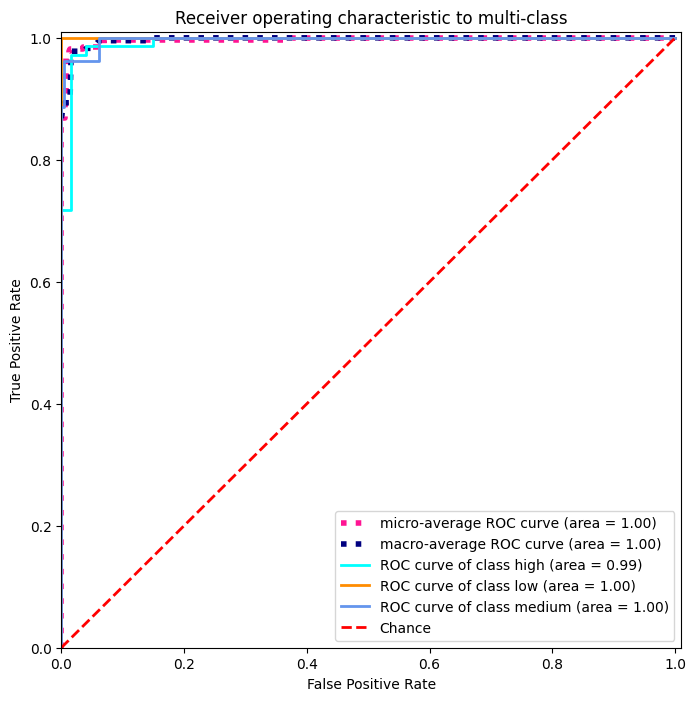

In [47]:
Plot_ROC(model, valid_loader)

In [48]:
def Predictor(net, valid_loader):
    try:
        json_file = open('./classes_indices.json', 'r')
        class_indict = json.load(json_file)
    except Exception as e:
        print(e)
        exit(-1)

    y_true, y_pred = [], []
    errors = 0
    net.eval()
    net.load_state_dict(torch.load('./model.pth')['model'])
    with torch.no_grad():
        for step, data in enumerate(valid_loader):
            x, y = data
            x, y = x.to(device), y.to(device)
            predictions = net(x)
            predictions = torch.argmax(
                torch.softmax(predictions, dim=1), dim=1)
            for i in range(len(predictions)):
                y_true.append(y[i].cpu())
                y_pred.append(predictions[i].cpu())

    tests = len(y_true)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1

    acc = (1 - errors / tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%')

    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    f1score = f1_score(ytrue, ypred, average='weighted') * 100
    print(f'The F1-score was {f1score:.3f}')

    class_count = len(list(class_indict.values()))
    classes = list(class_indict.values())

    cm = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=0, fontsize=14)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.1%')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=0, fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0, fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

there were 9 errors in 318 tests for an accuracy of  97.17%
The F1-score was 97.157


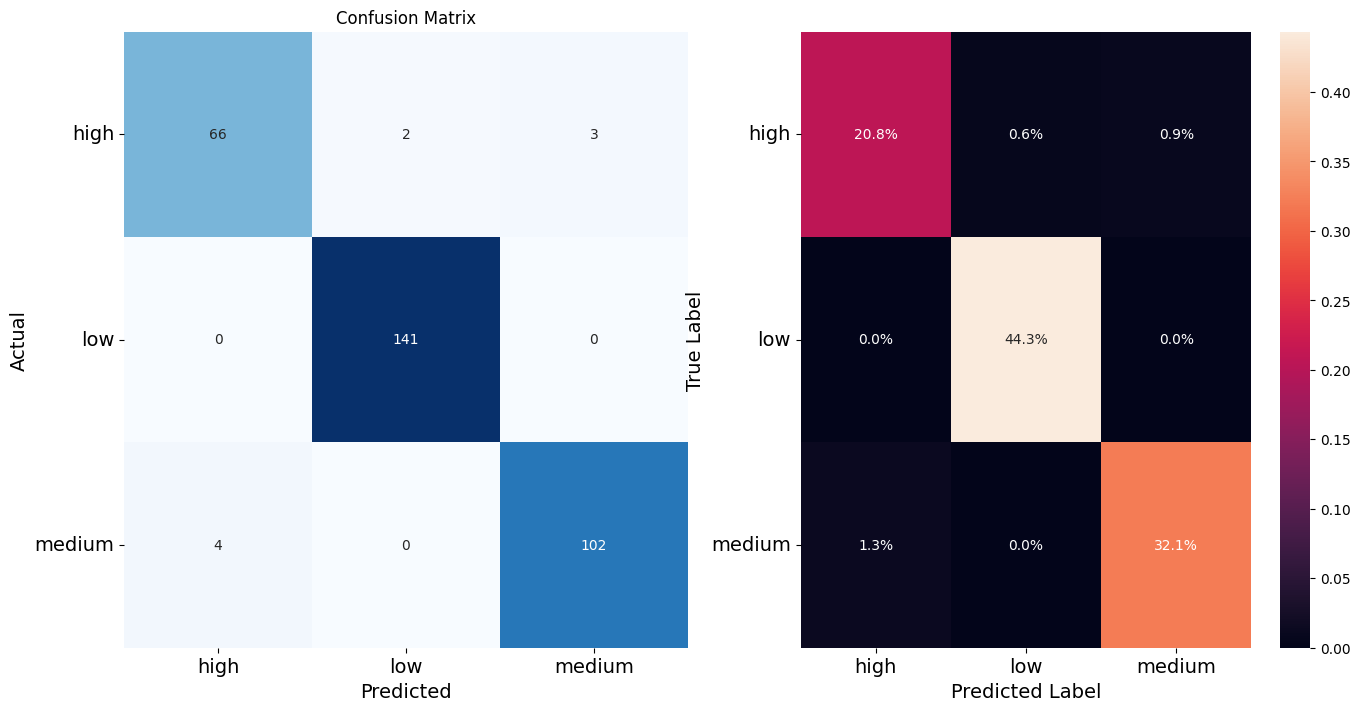

Classification Report:
----------------------
               precision    recall  f1-score   support

        high     0.9429    0.9296    0.9362        71
         low     0.9860    1.0000    0.9930       141
      medium     0.9714    0.9623    0.9668       106

    accuracy                         0.9717       318
   macro avg     0.9668    0.9639    0.9653       318
weighted avg     0.9715    0.9717    0.9716       318



In [49]:
Predictor(model, valid_loader)